In [2]:
from torch.utils.data import DataLoader
import sys
import numpy as np
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.autoencoder_ts import RecurrentAutoencoder
from model.loss_ae import *
from pre_train_autoencoder import *
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

## overfit model

In [3]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [4]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 154  
embedding_dim = 32
n_heads = 2
model = RecurrentAutoencoder(n_features, embedding_dim,n_heads).to(device)
som_layer = model.som


In [6]:

def plot_prob_and_trajectory(prob_q, k_all, som_dim, i_g, i_r, t_g, t_r, save_path):
    fig, ax = plt.subplots(1, 4, figsize=(50, 10))
    prob_q = prob_q.reshape(-1, som_dim[0], som_dim[1])
    
    # 绘制第一个样本的轨迹
    c = "green"
    k_1 = k_all[i_g] // som_dim[1]
    k_2 = k_all[i_g] % som_dim[1]
    ax[0].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
    ax[0].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label="Start")
    ax[0].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker=".")
    ax[0].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker="x", label="End")
    
    # 绘制第二个样本的轨迹
    c = "red"
    k_1 = k_all[i_r] // som_dim[1]
    k_2 = k_all[i_r] % som_dim[1]
    ax[0].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
    ax[0].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label="Start")
    ax[0].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker=".")
    ax[0].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker="x", label="End")
    ax[0].legend(loc=2, prop={"size": 20})
    
    # 绘制概率分布叠加轨迹
    for it in range(3):
        cc = it + 1
        t = t_g[it]
        sns.heatmap(prob_q[i_g, t], cmap="Blues", ax=ax[cc], cbar=(it == 2))
        k_1 = k_all[i_g] // som_dim[1]
        k_2 = k_all[i_g] % som_dim[1]
        ax[cc].plot(k_2[:t + 1] + 0.5, k_1[:t + 1] + 0.5, color="green", linewidth=7)
        ax[cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color="green", s=800)
        
        t = t_r[it]
        sns.heatmap(prob_q[i_r, t], cmap="Blues", ax=ax[cc], cbar=(it == 2))
        k_1 = k_all[i_r] // som_dim[1]
        k_2 = k_all[i_r] % som_dim[1]
        ax[cc].plot(k_2[:t + 1] + 0.5, k_1[:t + 1] + 0.5, color="red", linewidth=7)
        ax[cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color="red", s=800)
    
    plt.savefig(save_path)
    plt.close()

In [ ]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/pre_train/best_model.pth'

class TrainingScheduler:
    def __init__(self, model, warmup_epochs=30, lambda_config=None):
        self.model = model
        self.warmup_epochs = warmup_epochs
        self.lambda_config = lambda_config or {
            'mae': 1.0,
            'l2': 1e-4,
            'recon_smooth': 0.1,
            'kl': 1.0,
            'diversity': 0.5,
            'smooth': 0.3,
            'neighbor': 0.2
        }

    def configure_epoch(self, epoch):
        self.model.use_som = epoch >= self.warmup_epochs

def train_model(model, train_loader, val_loader, n_epochs, save_path):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history = {
        'train': [], 'val': [],
        'kl_loss': [], 'diversity_loss': [], 'smooth_loss': [], 'neighbor_loss': [],
        'mae_loss': [], 'recon_smooth_loss': [], 'l2_loss': []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    scheduler = TrainingScheduler(model)

    for epoch in range(1, n_epochs + 1):
        scheduler.configure_epoch(epoch)
        model.train()
        train_losses = []
        for seq_true, seq_lengths in train_loader:
            optimizer.zero_grad()
            seq_true, seq_lengths = seq_true.to(device), seq_lengths.to(device)
            output = model(seq_true, seq_lengths)
            loss, loss_dict = compute_total_loss(output, seq_true, seq_lengths, model, scheduler.lambda_config, device)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        val_metrics = {
            'kl_loss': [], 'diversity_loss': [], 'smooth_loss': [], 'neighbor_loss': [],
            'mae_loss': [], 'recon_smooth_loss': [], 'l2_loss': []
        }
        with torch.no_grad():
            for seq_true, seq_lengths in val_loader:
                seq_true, seq_lengths = seq_true.to(device), seq_lengths.to(device)
                output = model(seq_true, seq_lengths)
                loss, loss_dict = compute_total_loss(output, seq_true, seq_lengths, model, scheduler.lambda_config, device)
                val_losses.append(loss.item())
                for k in val_metrics:
                    v = loss_dict[k]
                    val_metrics[k].append(v.item() if isinstance(v, torch.Tensor) else float(v))

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)
        for k in val_metrics:
            history[k].append(np.mean(val_metrics[k]))

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train {train_loss:.4f}, val {val_loss:.4f}, use_som={model.use_som}")

    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [8]:
def plot_loss_trend(history):
    plt.figure(figsize=(14, 5))

    # 总体训练 & 验证误差
    plt.subplot(1, 2, 1)
    plt.plot(history['train'], label='Train Total Loss')
    plt.plot(history['val'], label='Val Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overall Loss (Train vs Val)")
    plt.legend()
    plt.grid(True)

    # 各损失项细节
    plt.subplot(1, 2, 2)
    keys_to_plot = ['kl_loss', 'diversity_loss', 'smooth_loss', 'neighbor_loss', 'mae_loss', 'recon_smooth_loss']
    for key in keys_to_plot:
        if key in history:
            plt.plot(history[key], label=key)
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.title("Component Losses")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
def visualize_recons(model, data_loader, num_patients, feature_indices, feature_names):
    """
    Visualize the reconstruction of selected features for a given number of patients.

    Args:
        model: The trained model.
        data_loader: DataLoader for the dataset.
        num_patients: Number of patients to visualize.
        feature_indices: List of feature indices to visualize.
        feature_names: List of feature names corresponding to the dataset.
    """
    model.eval()  
    with torch.no_grad():
        inputs, lengths = next(iter(data_loader))  
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        outputs = model(inputs, lengths)  
        outputs = outputs["x_hat"]
        outputs = outputs.cpu()

    inputs_sample = inputs[:num_patients].cpu().numpy()        # (num_patients, seq_len, n_features)
    outputs_sample = outputs[:num_patients].cpu().numpy()      # (num_patients, seq_len, n_features)
    lengths_sample = lengths[:num_patients].cpu().numpy()      # (num_patients,)

    num_features = len(feature_indices)  # Number of features to visualize
    fig, axes = plt.subplots(num_patients, num_features, figsize=(15, 10))

    for i in range(num_patients):
        effective_length = int(lengths_sample[i])
        for j, feature_idx in enumerate(feature_indices):
            ax = axes[i, j] if num_patients > 1 else axes[j]
            input_seq = inputs_sample[i, :effective_length, feature_idx]
            output_seq = outputs_sample[i, :effective_length, feature_idx]
            
            ax.plot(range(effective_length), input_seq, label="Original", linestyle="dotted", color="blue")
            ax.plot(range(effective_length), output_seq, label="Reconstructed", alpha=0.7, color="red")
            
            if i == 0:
                ax.set_title(feature_names[feature_idx], fontsize=12)  # 使用 feature_names[feature_idx] 作为标题
            if j == 0:
                ax.set_ylabel(f"Patient {i+1}", fontsize=12)
            ax.legend(fontsize=8, loc="upper right")
            
    plt.xlabel("Time Step")
    plt.tight_layout()
    plt.show()

In [ ]:
model, history = train_model(model, train_loader, val_loader, n_epochs=100, save_path=save_path)


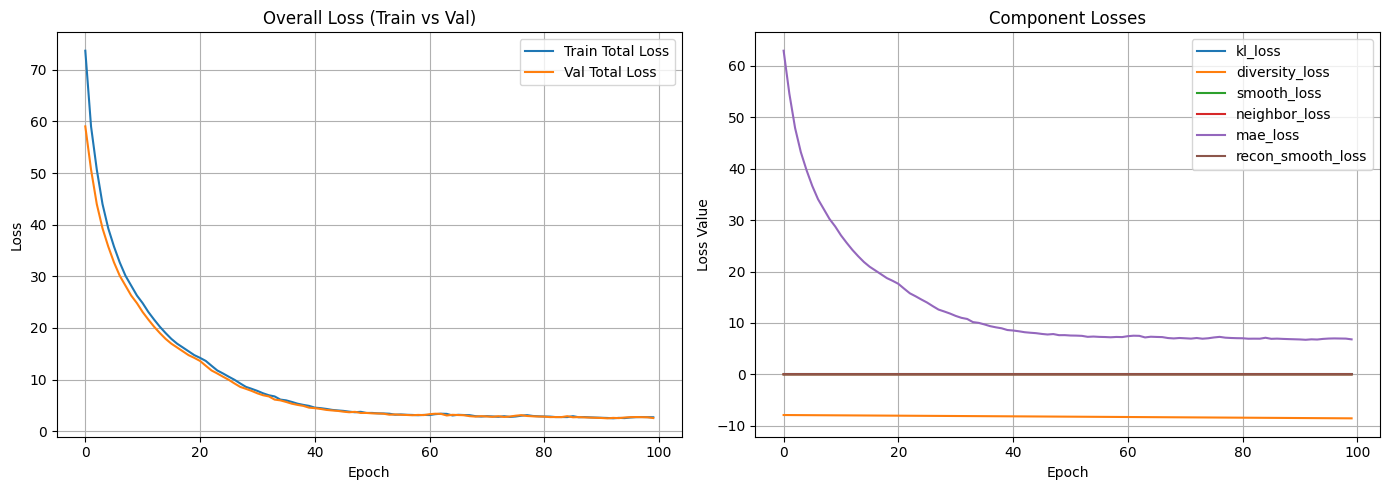

In [10]:
plot_loss_trend(history)

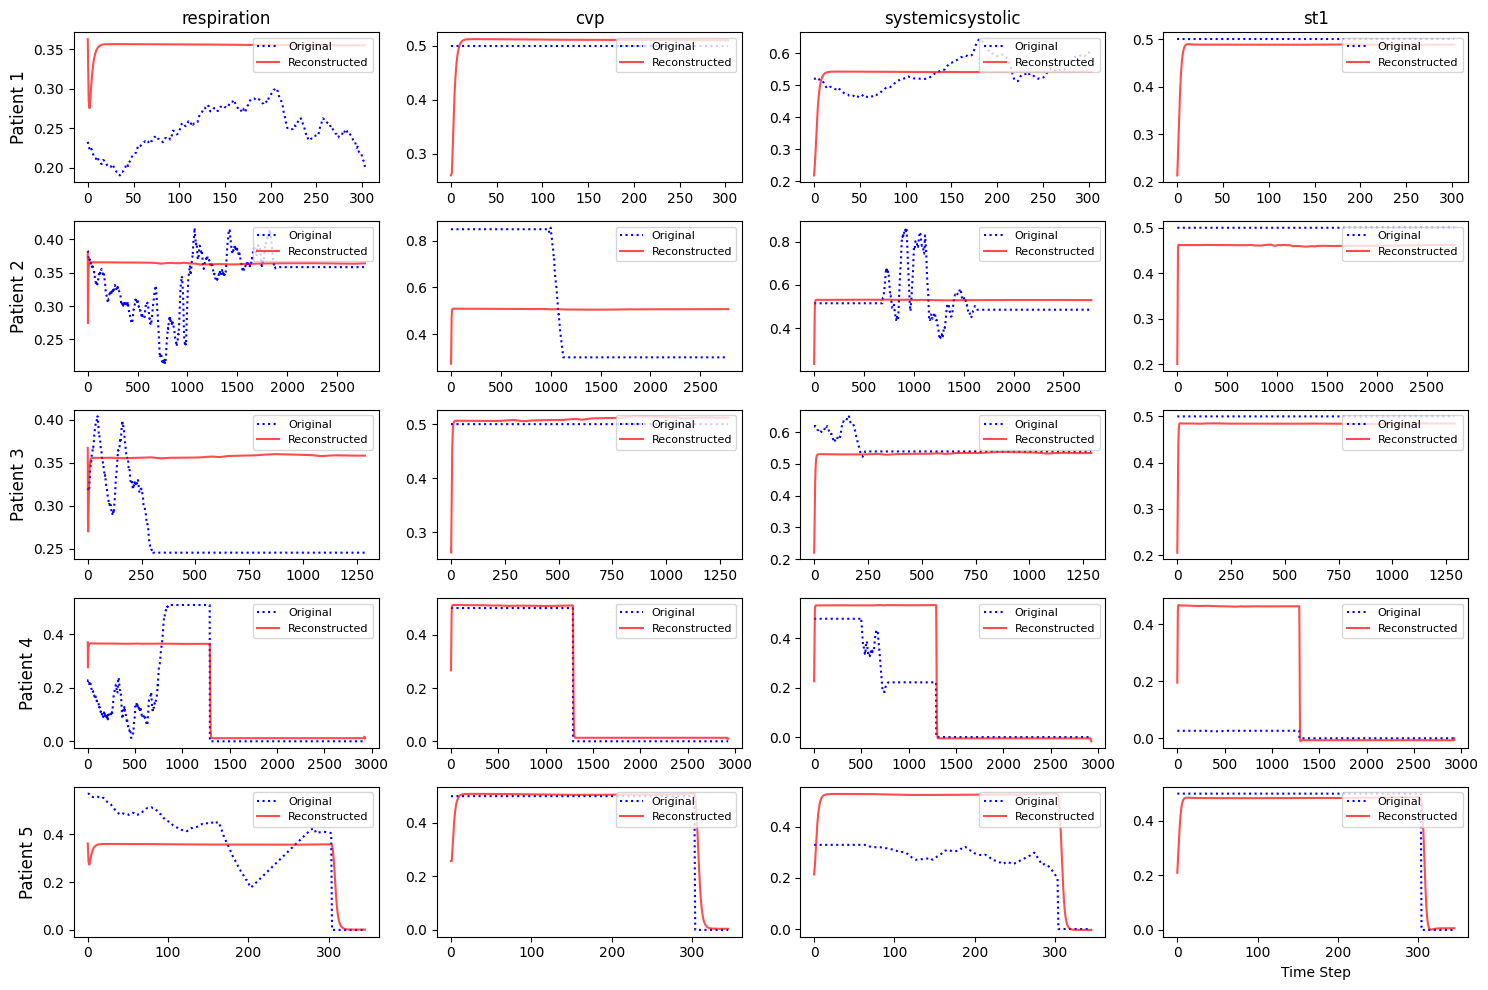

In [14]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [ 146,147,148,151]  # 
visualize_recons(model, small_train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features)

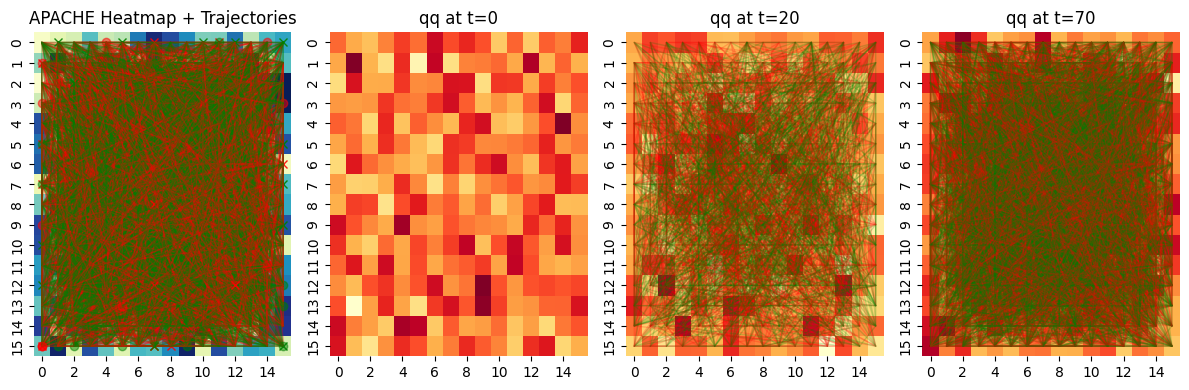

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Mock data
som_dim = (16, 16)
sd = som_dim[0] * som_dim[1]
num_samples = 100
timesteps = 80

# Trajectory positions (k_all): integers in [0, sd)
k_all = np.random.randint(0, sd, size=(num_samples, timesteps))

# Soft assignments (qq): [num_samples, timesteps, sd]
qq = np.random.rand(num_samples, timesteps, sd)
qq /= qq.sum(axis=-1, keepdims=True)  # Normalize

# Labels: 0 = survived (green), 1 = died (red)
labels_val_all = np.random.randint(0, 2, size=(num_samples,))

# APACHE-like clust_matr1 for left heatmap
clust_matr1 = np.random.rand(sd)
clust_matr1_reshaped = clust_matr1.reshape(som_dim)

# Coordinate helpers
def get_coords(indices):
    return np.array([(i // som_dim[1], i % som_dim[1]) for i in indices])

# Create the figure
fig = plt.figure(figsize=(12, 4))

# --- Left: Main heatmap with trajectories ---
ax1 = fig.add_subplot(1, 4, 1)
sns.heatmap(clust_matr1_reshaped, ax=ax1, cmap="YlGnBu", cbar=False)
ax1.set_title("APACHE Heatmap + Trajectories")

# Overlay trajectories
for i in range(num_samples):
    coords = get_coords(k_all[i])
    color = 'green' if labels_val_all[i] == 0 else 'red'
    ax1.plot(coords[:, 1] + 0.5, coords[:, 0] + 0.5, color=color, alpha=0.3, linewidth=1)
    ax1.plot(coords[0, 1] + 0.5, coords[0, 0] + 0.5, 'o', color=color, alpha=0.5)  # start
    ax1.plot(coords[-1, 1] + 0.5, coords[-1, 0] + 0.5, 'x', color=color, alpha=0.9)  # end

# --- Right: qq snapshots at time 0, 20, 70 ---
for j, t in enumerate([0, 20, 70]):
    ax = fig.add_subplot(1, 4, j + 2)
    mean_qq_t = qq[:, t, :].mean(axis=0).reshape(som_dim)
    sns.heatmap(mean_qq_t, ax=ax, cmap="YlOrRd", cbar=False)
    ax.set_title(f"qq at t={t}")

    # Overlay truncated trajectories up to time t
    for i in range(num_samples):
        coords = get_coords(k_all[i, :t+1])
        color = 'green' if labels_val_all[i] == 0 else 'red'
        ax.plot(coords[:, 1] + 0.5, coords[:, 0] + 0.5, color=color, alpha=0.2, linewidth=1)

plt.tight_layout()
plt.show()
